In [1]:
import os
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from PIL import Image
from transformers import CLIPTextModel, CLIPTokenizer, logging

# Setup
diffusion_model_id = 'runwayml/stable-diffusion-v1-5'
text_encoder_model_id = 'openai/clip-vit-large-patch14'
device = 'cuda'
logging.set_verbosity_error()

# Textual inversion settings
property_name = 'pyraminx'  # Name of learned property
placeholder_token = f'<{property_name.replace("_", "-")}>'  # Token that represents new property
saved_models_path = f'saved_models/textual_inversion/{property_name}'
final_model_path = f'saved_models/textual_inversion/{property_name}/{property_name}_final.pt'
generated_images_path = f'generated_images/textual_inversion/{property_name}'
if not os.path.isdir(generated_images_path):
    os.makedirs(generated_images_path)
timeline = True  # Timeline of image generation through training

# Hugging Face access token
token = ''
with open('hugging_face_token.txt', 'r') as secret:
    token = secret.readline().strip()

In [2]:
# Load model components

# Text Encoder + Tokenizer
tokenizer = CLIPTokenizer.from_pretrained(text_encoder_model_id)
text_encoder = CLIPTextModel.from_pretrained(text_encoder_model_id, torch_dtype=torch.float16)

# Variational Autoencoder
vae = AutoencoderKL.from_pretrained(
    diffusion_model_id, subfolder='vae', torch_dtype=torch.float16,
    revision='fp16', use_auth_token=token)
vae.to(device)

# U-Net Model
u_net = UNet2DConditionModel.from_pretrained(
    diffusion_model_id, subfolder='unet', torch_dtype=torch.float16,
    revision='fp16', use_auth_token=token)
u_net.to(device)

# Noise Scheduler
scheduler = PNDMScheduler.from_config(diffusion_model_id, subfolder='scheduler', use_auth_token=token)

In [3]:
# Setup tokenizer and text encoder

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)

# Convert the placeholder token to ids
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

# Resize the token embeddings as we are adding new special tokens to the tokenizer
text_encoder.resize_token_embeddings(len(tokenizer))

# Initialize the newly added placeholder token embedding
token_embeds = text_encoder.get_input_embeddings().weight.data

# Send text encoder to GPU
text_encoder.to(device)
print('Loaded model successfully!')

Loaded model successfully!


In [4]:
# Auxiliary functions

# Encode input prompt
def encode_prompt(prompt):
    text_inputs = tokenizer(
        prompt, padding='max_length', max_length=tokenizer.model_max_length,
        truncation=True, return_tensors='pt')
    with torch.no_grad():
        text_embeddings = text_encoder(text_inputs.input_ids.to(device))[0]
    return text_embeddings

# Prepare latents for denoising
def prepare_latents(height=512, width=512, latents=None):
    if latents is None:
        shape = (1, u_net.in_channels, height // 8, width // 8)
        latents = torch.randn(shape, device=device, dtype=torch.float16)
    latents = latents.to(device)
    latents *= scheduler.init_noise_sigma
    return latents

# Decode latents into an image
def decode_latents(latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()
    return image

In [5]:
# Model evaluation
def eval_model(prompt, num_inference_steps=50, guidance_scale=7.5, seed=1024):
    # Set random seed
    torch.manual_seed(seed)

    # Encode input prompt
    prompt_embeddings = encode_prompt(prompt)

    # Add unconditional embeddings for guidance scale
    unconditional_input = tokenizer(
        [''], padding='max_length', max_length=tokenizer.model_max_length,
        truncation=True, return_tensors='pt')
    with torch.no_grad():
        unconditional_embeddings = text_encoder(unconditional_input.input_ids.to(device))[0]

    # Concatenate for final embeddings
    text_embeddings = torch.cat([unconditional_embeddings, prompt_embeddings])

    # Prepare timesteps
    scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = scheduler.timesteps

    # Prepare latent variables
    latents = prepare_latents()

    # Denoising Loop
    for i, t in enumerate(timesteps):
        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        with torch.no_grad():
            noise_pred = u_net(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        noise_pred_unconditional, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_unconditional + guidance_scale * (noise_pred_text - noise_pred_unconditional)

        # Compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents
    decoded = decode_latents(latents)

    # Return image
    images = (decoded * 255).round().astype('uint8')
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images[0]

A photo of a <pyraminx>


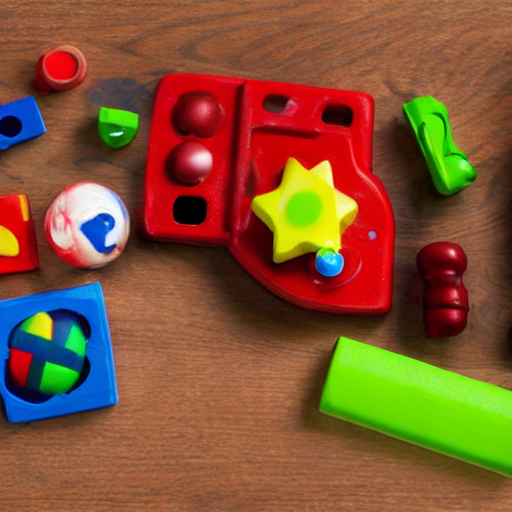

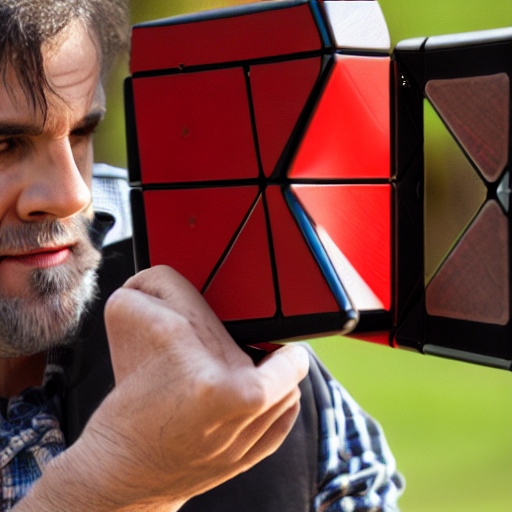

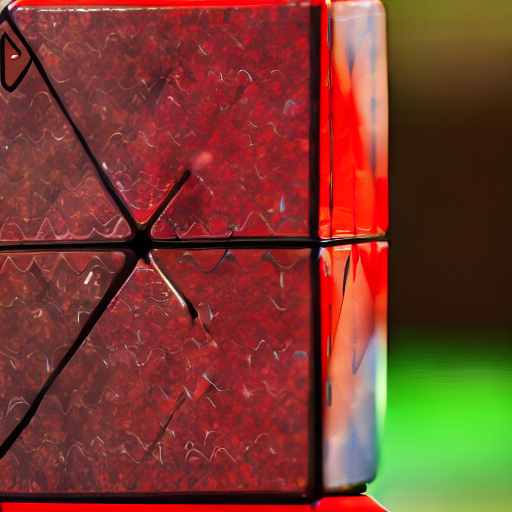

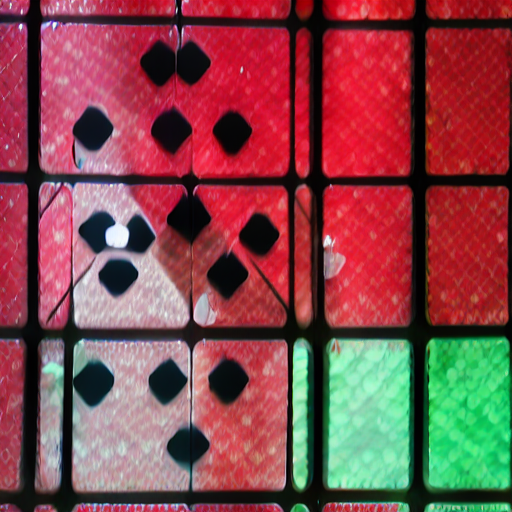

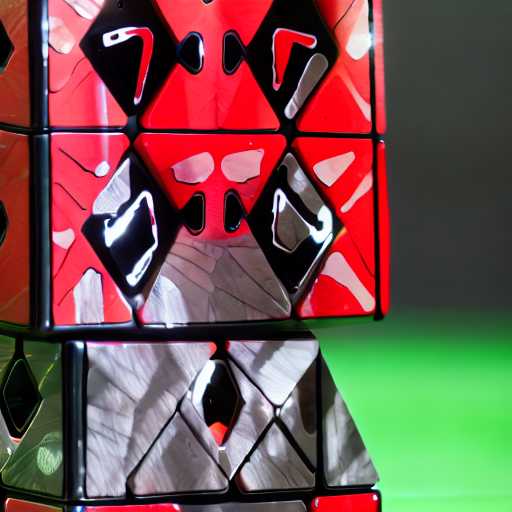

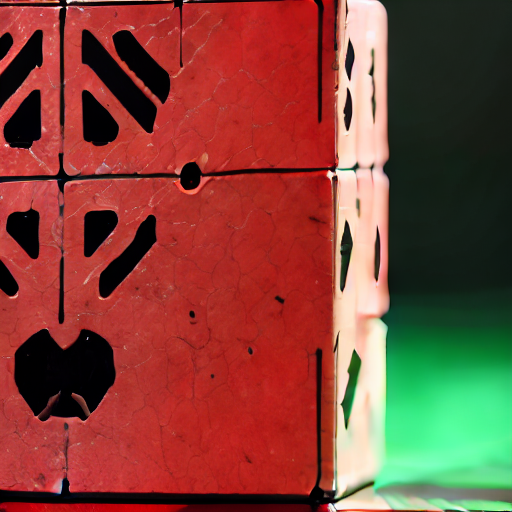

In [6]:
# Inference
prompt = f'A photo of a {placeholder_token}'
print(prompt)
seed = 1
guidance_scale = 7.5

# Timeline
version = 0
while timeline:
    model_path = os.path.join(saved_models_path, f'{property_name}_{version}.pt')
    if not os.path.exists(model_path):
        break
    token_embeds = text_encoder.get_input_embeddings().weight.data
    token_embeds[placeholder_token_id] = torch.load(model_path)[placeholder_token]
    text_encoder.to(device)
    generated_img = eval_model(prompt, seed=seed, guidance_scale=guidance_scale)
    display(generated_img)
    generated_img.save(f'{generated_images_path}/{property_name}_{version}.png')
    version += 1

# Final image
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = torch.load(final_model_path)[placeholder_token]
text_encoder.to(device)
generated_img = eval_model(prompt, seed=seed, guidance_scale=guidance_scale)
display(generated_img)
generated_img.save(f'{generated_images_path}/{property_name}_final.png')